In [8]:
import numpy as np 
import pandas as pd
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import csv

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import PIL
from PIL import Image

import os
print(os.listdir('./dataset'))

['car_data', 'names.csv']


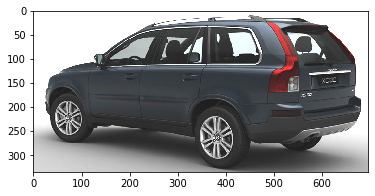

In [11]:
path_base = './dataset'
image = Image.open(path_base + '/car_data/car_data/train/Volvo XC90 SUV 2007/00954.jpg')
imgplot = plt.imshow(image)
plt.show()

In [12]:
class_names = []

with open(path_base + '/names.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile, delimiter=';')
    for row in csvReader:
        class_names.append(row[0])

print(class_names)

['Rolls-Royce Phantom Sedan 2012', 'Tesla Model S Sedan 2012', 'Volvo XC90 SUV 2007']


In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K

In [32]:
K.set_learning_phase(1)

img_width, img_height = 64, 64
nb_train_samples = 133
nb_validation_samples = 133
epochs = 5
batch_size = 16
n_classes = 3

In [33]:
train_data_dir = path_base + '/car_data/car_data/train'
validation_data_dir = path_base + '/car_data/car_data/test'

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    #shear_range=0.2,
    zoom_range=0.2,
    #fill_mode = 'constant',
    #cval = 1,
    rotation_range = 5,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 126 images belonging to 3 classes.
Found 125 images belonging to 3 classes.


In [34]:
def build_model():
    base_model = densenet.DenseNet121(input_shape=(img_width, img_height, 3),
                                     weights='imagenet',
                                     include_top=False,
                                     pooling='avg')
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [35]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse'])

In [36]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

In [37]:
model_history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks_list)

Epoch 1/5
7/8 [=========================>....] - ETA: 5s - loss: 598.6787 - acc: 0.3818 - mse: 0.2344 

KeyboardInterrupt: 